In [1]:
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter

In [2]:
import grpc

import Api_pb2 as api
import Api_pb2_grpc as api_grpc
import pandas as pd
# import route_guide_resources

    

In [3]:
# int(timeFrom.timestamp())

In [7]:
# int(timeTo.timestamp())

In [8]:
records_df = pd.DataFrame(columns=['device_code', 
                            'state_number',
                            'course',
                            'device_time',
                            'state',
                            'longitude',
                            'latitude',
                            'altitude',
                            'speed', 
                            'accelerations',
                            'fuel_spent',
                            'satellites'
                            'valid',
                            'hdop'])

Подписка на поток

In [10]:
timeFrom = pd.to_datetime("2020-09-13 21:00:00", format='%Y-%m-%d %H:%M:%S')
timeTo = pd.to_datetime("2020-09-15 21:00:00", format='%Y-%m-%d %H:%M:%S')

rangeStreamRequest = api.ObjectsDataRangeRequest(
    Filter= api.DataFilter(
        DateFrom= 			int(timeFrom.timestamp()),
        DateTo= 			int(timeTo.timestamp()),
        Subsystem= 			"kiutr", # для мусоровозов - garbade, на тестовом стенде данные по garbage отсутствуют 
        # ExcludeDeviceCode= 	["10033473", "404957","500459"], # пример исключения уже обработанных блоков
        # DeviceCode=			["10033473","404957"],  # дополнительные коды БНСО
        # StateNumber= 		["Н040РА195"],  # дополнительные госномера
    ),
    Fields = api.FieldsToggle(
        Position=True # запрашивает только навигационную информацию
    )
)



In [11]:
endpoint_address = 'rnis-tm.t1-group.ru:18082'
# endpoint_address = 'rnis-tm.t1-group.xu:000000'

# localhost = 'localhost:50051'
max_records = 250
with grpc.insecure_channel(endpoint_address) as channel:

    print("------------Create Stub--------------")
    stub = api_grpc.APIStub(channel)
    print(stub)
    
    print("------------Get DataStream-----------")
    stream = stub.GetObjectsDataStream(rangeStreamRequest)
    # stream = script.get_data_stream(stub)
    print(stream)

    print("------ Retreive data from stream-----")
    i = 0
    for data_point in stream:
        i += 1
        if i == max_records:
            break


        device_time = data_point.DeviceTime
        device_code = data_point.DeviceCode
        gps_data = data_point.Position
        accelerations = data_point.Accelerations

        longitude = gps_data.Longitude
        latitude = gps_data.Latitude
        altitude = gps_data.Altitude
        course = gps_data.Course
        speed = gps_data.Speed
        valid = gps_data.Valid
        hdop = gps_data.HDOP

        if i%20 == 0:
            print('datapoint ', i)
        # print('device_code: ', device_code)
        # print('device_time: ', device_time)
        # print('longitude: ', longitude)
        # print('latitude: ', latitude)
        # print('altitude: ', altitude)
        # print('course: ', course)
        # print('speed: ', speed)
        # print('accelerations: ', accelerations)
        # print('valid: ', valid)
        # print('hdop: ', hdop)
        # print()

        # add to dataframe
        record = {
            'device_code': device_code,
            # 'state_number': object_data.StateNumber,
            'device_time': device_time,            
            # 'state': data_point.ObjectState,
            # 'received_time': data_point.ReceivedTime,
            'accelerations': accelerations,
            # 'fuel_spent': data_point.FuelSpent,
            'longitude': longitude,
            'latitude': latitude,
            'altitude': altitude,
            'course': course,
            # 'satellites': satellites,
            'speed': speed,
            'valid': valid,
            'hdop': hdop,
        }

        records_df = records_df.append(record, ignore_index=True)

------------Create Stub--------------
------------Get DataStream-----------
<_MultiThreadedRendezvous object>
------ Retreive data from stream-----
datapoint  20
datapoint  40
datapoint  60
datapoint  80
datapoint  100
datapoint  120
datapoint  140
datapoint  160
datapoint  180
datapoint  200
datapoint  220
datapoint  240


In [10]:
channel.close()

process time and save

In [13]:
records_df['time'] = records_df.device_time.apply(lambda x: pd.Timestamp(x,  unit='s'))

In [14]:
records_df.to_csv('data/records_249.csv', index=False)

In [4]:
records_df = pd.read_csv('data/records_249.csv')

group by course

In [5]:
# Counter(records_df.course)

In [6]:
course_df = records_df.groupby('course').agg({'time': tuple, 'longitude':tuple, 'latitude':tuple, 'device_code':tuple})

In [7]:
course_df['number_of_devices'] = course_df.device_code.apply(lambda x: len(np.unique(x)))

In [9]:
course_df.head()

,time,longitude,latitude,device_code,number_of_devices
course,,,,,
0,"(2020-11-17 15:59:58, 2020-11-17 15:49:30, 202...","(43.970780084834146, 43.939234624602655, 43.89...","(56.30289317488272, 56.30653025030776, 56.2555...","(865473034025067, 866795039032329, 86547303401...",15
2,"(2020-11-17 16:00:00,)","(44.07560219617457,)","(56.361116535580045,)","(60044011,)",1
12,"(2020-11-17 16:00:04,)","(43.29175473267485,)","(54.9154293665,)","(EEEEEEEEE119708,)",1
18,"(2020-11-17 16:00:03,)","(43.343516002256315,)","(54.92065967408024,)","(EEEEEEEEE118645,)",1
20,"(2020-11-17 16:00:01, 2020-11-17 16:00:06)","(43.29060406500721, 43.29060406500721)","(54.915869248778534, 54.915869248778534)","(EEEEEEEEE118651, EEEEEEEEE118651)",1


In [11]:
# records_df['time'][0].date()

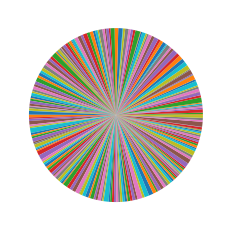

In [15]:
plt.pie(records_df.course)
plt.show()

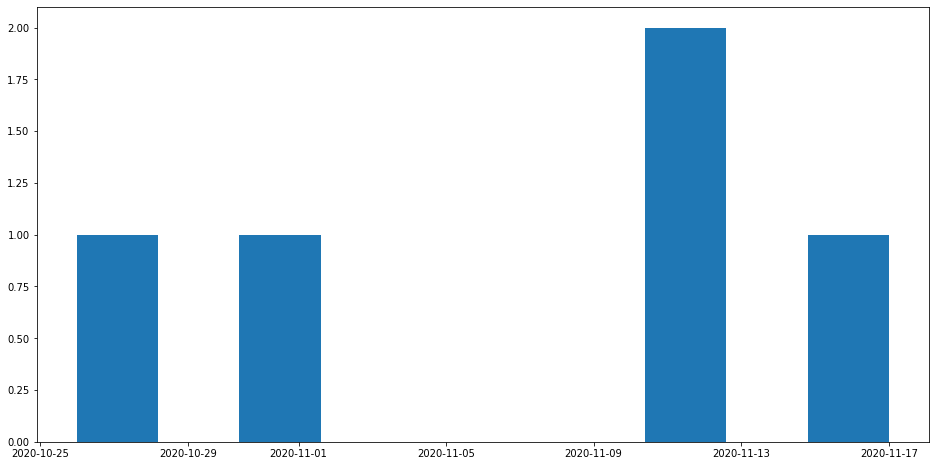

In [50]:
dates = np.unique(records_df['time'].apply(lambda x:x.date()))

plt.figure(figsize=(16,8))
plt.hist(dates)
plt.show()

In [25]:
records_df['time'].min()

Timestamp('2020-09-04 11:33:11')

In [12]:
records_df.head(10)

,device_code,state_number,course,device_time,state,longitude,latitude,altitude,speed,accelerations,fuel_spent,satellitesvalid,hdop,valid
0,EEEEEEEEEE58569,NaN,129,1605540497,NaN,43.321439,54.921454,0.0,0,,NaN,NaN,0,0.0
1,46112611,NaN,67,1605540467,NaN,43.476800,56.238965,0.0,20,,NaN,NaN,0,0.0
2,46112611,NaN,78,1605540468,NaN,43.476902,56.238981,0.0,21,,NaN,NaN,0,0.0
3,46112611,NaN,83,1605540469,NaN,43.477018,56.238998,0.0,22,,NaN,NaN,0,0.0
4,46112611,NaN,80,1605540489,NaN,43.478874,56.239110,0.0,0,,NaN,NaN,0,0.0
5,40931529,NaN,189,1605540409,NaN,43.389020,56.226890,0.0,26,,NaN,NaN,0,0.0
6,40931529,NaN,178,1605540410,NaN,43.389014,56.226826,0.0,26,,NaN,NaN,0,0.0
7,40931529,NaN,124,1605540415,NaN,43.389328,56.226536,0.0,28,,NaN,NaN,0,0.0
8,40931529,NaN,113,1605540416,NaN,43.389443,56.226504,0.0,28,,NaN,NaN,0,0.0
9,40931529,NaN,102,1605540417,NaN,43.389570,56.226477,0.0,28,,NaN,NaN,0,0.0


In [ ]:
plt.pie(records_df.course)

In [14]:
len(records_df.course.unique())

64

(array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., 14.,  0.,  0.,  0., 83.]),
 array([737672.48137731, 737673.94464421, 737675.40791111, 737676.87117801,
        737678.33444491, 737679.79771181, 737681.2609787 , 737682.7242456 ,
        737684.1875125 , 737685.6507794 , 737687.1140463 , 737688.57731319,
        737690.04058009, 737691.50384699, 737692.96711389, 737694.43038079,
        737695.89364769, 737697.35691458, 737698.82018148, 737700.28344838,
        737701.74671528, 737703.20998218, 737704.67324907, 737706.13651597,
        737707.59978287, 737709.06304977, 737710.52631667, 737711.98958356,
        737713.45285046, 737714.91611736, 737716.37938426, 737717.84265116,
        737719.30591806, 737720.76918495, 737722.23245185, 737723.69571875,
        737725.15898565, 737726.

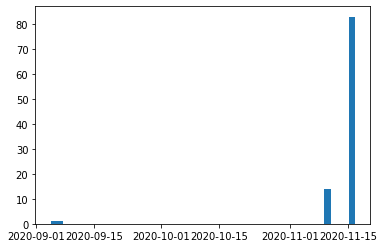

In [26]:
plt.hist(records_df.time, bins=50)

(array([ 7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 45.,  5.,  0., 19., 16.,  2.,  0.,  0.,  1.]),
 array([54.91184594, 54.94356198, 54.97527802, 55.00699407, 55.03871011,
        55.07042615, 55.10214219, 55.13385824, 55.16557428, 55.19729032,
        55.22900637, 55.26072241, 55.29243845, 55.3241545 , 55.35587054,
        55.38758658, 55.41930263, 55.45101867, 55.48273471, 55.51445076,
        55.5461668 , 55.57788284, 55.60959889, 55.64131493, 55.67303097,
        55.70474702, 55.73646306, 55.7681791 , 55.79989515, 55.83161119,
        55.86332723, 55.89504328, 55.92675932, 55.95847536, 55.99019141,
        56.02190745, 56.05362349, 56.08533954, 56.11705558, 56.14877162,
        56.18048767, 56.21220371, 56.24391975, 56.2756358 , 56.30735184,
        56.33906788, 56.37078393, 56.40249997, 56.43421601,

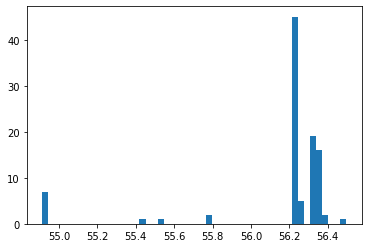

In [19]:
plt.hist(records_df.latitude, bins=50)

Получение данных по фильтру

In [16]:
timeFrom = pd.to_datetime("2020-09-13 21:00:00", format='%Y-%m-%d %H:%M:%S')
timeTo = pd.to_datetime("2020-09-14 21:00:00", format='%Y-%m-%d %H:%M:%S')

rangeStreamRequest = api.ObjectsDataRangeRequest(
    Filter= api.DataFilter(
        # DateFrom= 			int(timeFrom.timestamp()),
        # DateTo= 			int(timeTo.timestamp()),
        # Subsystem= 			"kiutr", # для мусоровозов - garbade, на тестовом стенде данные по garbage отсутствуют 
        # ExcludeDeviceCode= 	["10033473", "404957","500459"], # пример исключения уже обработанных блоков
        # DeviceCode=			["10033473","404957"],  # дополнительные коды БНСО
        # StateNumber= 		["Н040РА195"],  # дополнительные госномера
    ),
    Fields = api.FieldsToggle(
        Position=True # запрашивает только навигационную информацию
    )
)



In [17]:
import get_datapoints_stream as script

In [18]:
endpoint_address = 'rnis-tm.t1-group.ru:18082'
# endpoint_address = 'rnis-tm.t1-group.xu:000000'

# localhost = 'localhost:50051'
with grpc.insecure_channel(endpoint_address) as channel:

    print("------------Create Stub--------------")
    stub = api_grpc.APIStub(channel)
    print(stub)
    
    print("------------Get DataStream-----------")
    stream = stub.GetObjectsDataRangeAsStream(rangeStreamRequest)
    # stream = script.get_data_stream(stub)
    print(stream)

    print("------ Retreive data from stream-----")
    i = 0
    for object_data in stream:
        i += 1
        if i == 5:
            break

        device_code = object_data.DeviceCode
        # state_number = object_data.StateNumber
        data_point = object_data.DataPoint

        device_time = data_point.DeviceTime
        gps_data = data_point.Position
        state = data_point.ObjectState
        # received_time = data_point.ReceivedTime
        accelerations = data_point.Accelerations
        # fuel_spent = data_point.FuelSpent

        longitude = gps_data.Longitude
        latitude = gps_data.Latitude
        altitude = gps_data.Altitude
        course = gps_data.Course
        # satellites = gps_data.Satellites
        speed = gps_data.Speed
        valid = gps_data.Valid
        hdop = gps_data.HDOP

        print('datapoint ', i)
        print('device_code: ', device_code)
        print('device_time: ', device_time)
        print('state: ', state)
        print('longitude: ', longitude)
        print('latitude: ', latitude)
        print('altitude: ', altitude)
        print('course: ', course)
        print('speed: ', speed)
        print('accelerations: ', accelerations)
        print('valid: ', valid)
        print('hdop: ', hdop)
        print()

------------Create Stub--------------
------------Get DataStream-----------
<_MultiThreadedRendezvous object>
------ Retreive data from stream-----


In [13]:
# with grpc.insecure_channel(endpoint_address) as channel:

#     print("------------Create Stub--------------")
#     stub = api_grpc.APIStub(channel)
#     print(stub)
    
#     print("------------Get DataStream-----------")
#     stream = stub.GetObjectsDataRangeAsStream(rangeStreamRequest)
#     # stream = script.get_data_stream(stub)
#     print(stream)

In [14]:
print("------------Open Channel--------------")
channel = grpc.insecure_channel(endpoint_address)
channel




------------Open Channel--------------


In [15]:
print("------------Create Stub--------------")
stub = api_grpc.APIStub(channel)
stub



------------Create Stub--------------


In [16]:
print("------------Get DataStream-----------")
stream = stub.GetObjectsDataRangeAsStream(rangeStreamRequest)
# stream = script.get_data_stream(stub)
stream

------------Get DataStream-----------


<_MultiThreadedRendezvous object>

In [17]:
for _ in stream:
    print(_)

_

<_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.OK
	details = ""
>

In [11]:
print("------------Close Channel--------------")
channel.close()

------------Close Channel--------------


In [16]:
# records_df = pd.DataFrame(columns=['device_code', 
#                             'state_number',
#                             'course',
#                             'device_time',
#                             'state',
#                             'longitude',
#                             'latitude',
#                             'altitude',
#                             'speed', 
#                             'accelerations',
#                             'fuel_spent',
#                             'satellites'
#                             'valid',
#                             'hdop'])

    
# with grpc.insecure_channel(endpoint_address) as channel:
#     print("------------Create Stub--------------")
#     stub = api_grpc.APIStub(channel)

#     print("------------Get DataStream-----------")
#     stream = stub.GetObjectsDataRangeAsStream(rangeStreamRequest)

#     print("------ Retreive data from stream-----")

#     i = 0
#     for object_data in stream:
#         i += 1
#         if i == max_records:
#             break

#         data_point = object_data.DataPoint
#         gps_data = data_point.Position
#         record = {
#             'device_code': object_data.DeviceCode,
#             'state_number': object_data.StateNumber,
#             'device_time': data_point.DeviceTime,            
#             'state': data_point.ObjectState,
#             'received_time': data_point.ReceivedTime,
#             'accelerations': data_point.Accelerations,
#             'fuel_spent': data_point.FuelSpent,
#             'longitude': gps_data.Longitude,
#             'latitude': gps_data.Latitude,
#             'altitude': gps_data.Altitude,
#             'course': gps_data.Course,
#             'satellites': gps_data.Satellites,
#             'speed': gps_data.Speed,
#             'valid': gps_data.Valid,
#             'hdop': gps_data.HDOP,
#         }

------------Create Stub--------------
------------Get DataStream-----------
------ Retreive data from stream-----
